## 1. Implement models in Stan 

Call center data set — exponential likelihood with gamma prior. Estimate the number of calls per minute for the 11th hour of the call center data set.
Results to compute:
- Posterior 95% confidence interval over λ (check that it matches results in the
solution notebook below)
- Histogram of posterior λ samples

Resources for you to use:
- Data set: call_center.csv
- Solution for class activity (call_center_solution.ipynb)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
import scipy

waiting_times_day = pd.read_csv("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00073825-8976/call-center.csv", header = None)

current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day.iloc[:,0]:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)
    
hour_index = 11
waiting_times_hour = waiting_times_per_hour[hour_index]
plt.hist(waiting_times_hour, bins=20)
plt.title('Waiting times for hour %i' % hour_index)
plt.show()

<Figure size 640x480 with 1 Axes>

In [7]:
stan_code = """
data {  
    int<lower=1> N;
    real<lower=0> y[N];  // waiting time before call
    real<lower=0> alpha;
    real<lower=0> beta;
}

parameters {
    real<lower=0> lambda;  
}

model {
    lambda ~ gamma(alpha, beta);  // prior over p
    y ~ exponential(lambda);
}

"""

In [8]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_517b0b5d84655d237d93c53821eb81b3 NOW.


Inference for Stan model: anon_model_517b0b5d84655d237d93c53821eb81b3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
lambda  14.85    0.01   0.51  13.87  14.85  15.84   1467    1.0

Samples were drawn using NUTS at Tue Oct  9 22:04:48 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
Posterior 95% confidence interval for lambda: [13.86597784 15.84353943]


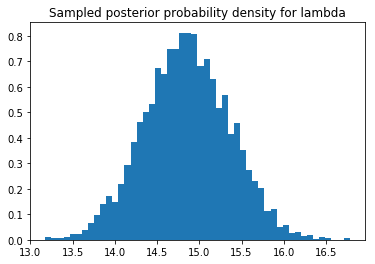

In [9]:
data = {'N': len(waiting_times_per_hour[11]), 
        'y': waiting_times_per_hour[11], 
        'alpha': 1,
       'beta': 0.25}

stan_results = stan_model.sampling(data=data)
print(stan_results.stansummary(pars=['lambda'], probs=[0.025, 0.5, 0.975]))

posterior_samples = stan_results.extract()
plt.hist(posterior_samples['lambda'], bins=50, density=True)
plt.title('Sampled posterior probability density for lambda')
print("Posterior 95% confidence interval for lambda:", np.percentile(posterior_samples['lambda'], [2.5, 97.5]))
plt.show()

# stan_model = pystan.stan(model_code=stan_code, data = data, init='init_r', iter=100000, warmup=1000, chains=4)

The 95% confidence interval of (13.87, 15.84) is comparable to the analytical confidence interval. 

### Comparison Set

Posterior α = 893.0, β = 60.1
Posterior 95% confidence interval over λ: [13.9, 15.9]


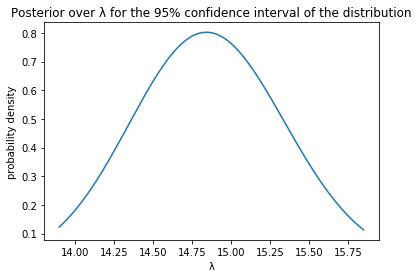

In [12]:
prior_alpha = 1
prior_beta = 0.25

posterior_alpha = prior_alpha + len(waiting_times_hour)
posterior_beta = prior_beta + sum(waiting_times_hour)
print('Posterior α = %.1f, β = %.1f' % (posterior_alpha, posterior_beta))

posterior = scipy.stats.gamma(a=posterior_alpha, scale=1/posterior_beta)

confidence_95 = (posterior.ppf(0.025), posterior.ppf(0.975))
print('Posterior 95%% confidence interval over λ: [%.1f, %.1f]' % confidence_95)

# Plot the posterior
x = np.linspace(confidence_95[0], confidence_95[1], 200)
y = posterior.pdf(x)
plt.plot(x, y)
plt.title('Posterior over λ for the 95% confidence interval of the distribution')
plt.xlabel('λ')
plt.ylabel('probability density')
plt.show()

## 2. Normal likelihood with normal-inverse-gamma prior
Results to compute:
- 95% posterior confidence intervals for the mean μ and variance σ of the data.
- Take 10 samples from your posterior over μ and σ^2 and plot the normal distributions corresponding to them. See Task 3 in the solutions below — you should produce a plot similar the one you find there.

In [2]:
stan_code = """
data {
   real mu;
   real nu;
   real<lower=0> alpha;
   real<lower=0> beta;
   int<lower=1> N;
   real y[N];
}

parameters {
    real mean_asdf;
    real<lower=0> variance_asdf;
}
model {
   mean_asdf ~ normal(mu, variance_asdf/nu);
   variance_asdf ~ inv_gamma(alpha, beta);
   y ~ normal(mean_asdf, variance_asdf);
}
generated quantities {
  real y_pred;
  y_pred = normal_rng(mean_asdf, variance_asdf);
}
"""

In [3]:
data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])

In [4]:
data = {'N': len(data), 
        'y': data, 
        'mu': 0,
        'nu':  0.054,
        'alpha': 1.12,
        'beta': 0.4,}
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad875b64e2d63114dc58bb945c856dd6 NOW.


In [5]:
stan_results = stan_model.sampling(data=data)
posterior_samples = stan_results.extract()
print(stan_results.stansummary(pars=['mean_asdf', 'variance_asdf'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_ad875b64e2d63114dc58bb945c856dd6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mean_asdf       3.06  2.6e-3   0.14    2.8   3.06   3.32   2777    1.0
variance_asdf    1.9  1.7e-3    0.1   1.73    1.9   2.11   3185    1.0

Samples were drawn using NUTS at Tue Oct  9 22:30:34 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 95% confidence interval for mu: [2.79690692 3.32478955]


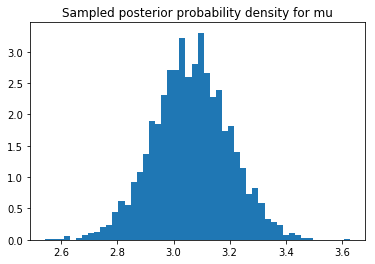

Posterior 95% confidence interval for variance: [1.72928976 2.1139888 ]


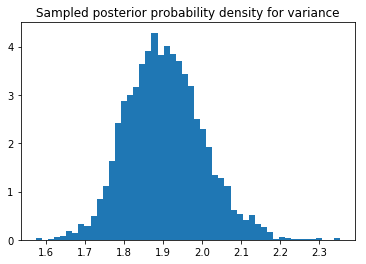

In [6]:
plt.hist(posterior_samples['mean_asdf'], bins=50, density=True)
plt.title('Sampled posterior probability density for mu')
print("Posterior 95% confidence interval for mu:", np.percentile(posterior_samples['mean_asdf'], [2.5, 97.5]))
plt.show()

plt.hist(posterior_samples['variance_asdf'], bins=50, density=True)
plt.title('Sampled posterior probability density for variance')
print("Posterior 95% confidence interval for variance:", np.percentile(posterior_samples['variance_asdf'], [2.5, 97.5]))
plt.show()

(array([0.00300013, 0.00100004, 0.00400017, 0.00100004, 0.00300013,
        0.0070003 , 0.0070003 , 0.01800078, 0.01700074, 0.01800078,
        0.04200183, 0.046002  , 0.04700204, 0.05800252, 0.05500239,
        0.0760033 , 0.10700465, 0.11000478, 0.13400582, 0.1450063 ,
        0.13700595, 0.20100874, 0.19200834, 0.17000739, 0.19800861,
        0.22400974, 0.21900952, 0.19600852, 0.19500847, 0.19300839,
        0.17500761, 0.15300665, 0.14900648, 0.13100569, 0.10000435,
        0.11000478, 0.08400365, 0.07400322, 0.05200226, 0.03500152,
        0.02600113, 0.02400104, 0.01700074, 0.01100048, 0.01400061,
        0.00500022, 0.01000043, 0.00200009, 0.00300013, 0.00100004]),
 array([-3.40877893, -3.15878979, -2.90880066, -2.65881152, -2.40882239,
        -2.15883325, -1.90884412, -1.65885498, -1.40886585, -1.15887671,
        -0.90888758, -0.65889844, -0.4089093 , -0.15892017,  0.09106897,
         0.3410581 ,  0.59104724,  0.84103637,  1.09102551,  1.34101464,
         1.59100378,  1.84

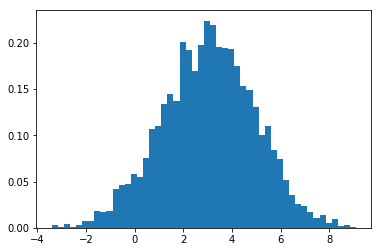

In [11]:
plt.hist(posterior_samples['y_pred'], bins=50, density=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


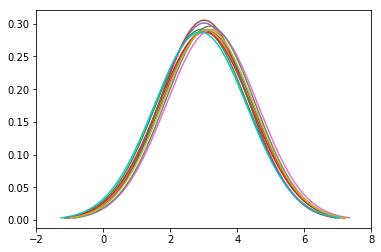

In [40]:
import matplotlib.mlab as mlab

x = np.random.choice(len(posterior_samples['mean_asdf']), 10)
meanarr, sdarr = posterior_samples['mean_asdf'][x], np.sqrt(posterior_samples['variance_asdf'][x])
for i in range(10):
    norm = np.linspace(meanarr[i] - 3*sdarr[i], meanarr[i] + 3*sdarr[i], 1000)
    plt.plot(norm, mlab.normpdf(norm, meanarr[i], sdarr[i] ))
    
plt.xlim(-2, 8)
plt.show()

## 3. Log-normal HRTEM data.
Normal likelihood log-transformed data and using a normal-inverse-gamma prior
Results to compute:
- 95% posterior confidence intervals for the μ and variance σ^2 of the log-transformed data. (Should match results under Task 3 of the solutions.)
- Take 10 samples from your posterior over μ and σ^2 and plot the log-normal distributions corresponding to them. See Task 5 in the solutions below — you should produce a plot similar the one you find there, but with 10 pdfs rather than one.

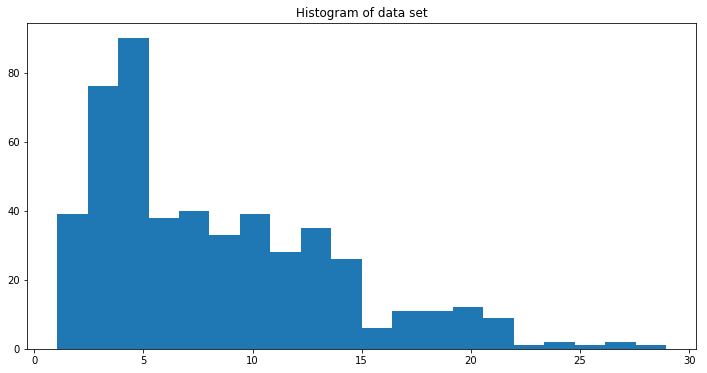

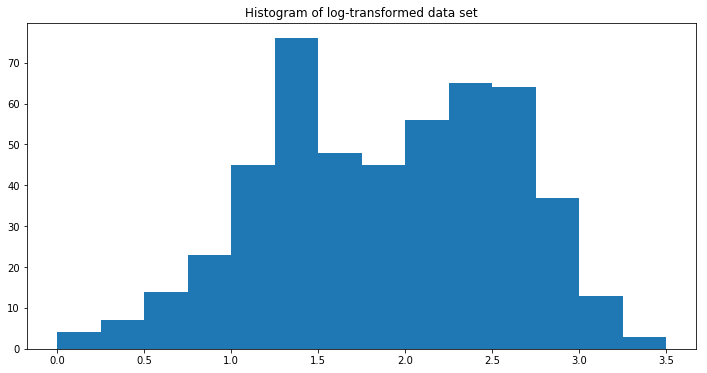

In [32]:
data = pd.read_csv("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv", header = None)
plt.figure(figsize=(12,6))
plt.hist(data.iloc[:,0], bins=20)
plt.title('Histogram of data set')
plt.show()
plt.figure(figsize=(12,6))
plt.hist(np.log(data.iloc[:,0]), bins=np.linspace(0, 3.5, 15))
plt.title('Histogram of log-transformed data set')
plt.show()

In [33]:
stan_code = """
data {
   real mu;
   real nu;
   real<lower=0> alpha;
   real<lower=0> beta;
   int<lower=1> N;
   real y[N];
}

parameters {
    real mean_asdf;
    real<lower=0> variance_asdf;
}
model {
   mean_asdf ~ normal(mu, variance_asdf/nu);
   variance_asdf ~ inv_gamma(alpha, beta);
   y ~ normal(mean_asdf, variance_asdf);
}
generated quantities {
  real y_pred;
  for(i in 1:10){
     y_pred = normal_rng(mean_asdf, variance_asdf);
  }
}
"""

In [34]:
data = {'y':np.log(data.iloc[:,0]),
        'N': len(np.log(data.iloc[:,0])),
        'mu': 2.3,
        'nu': 0.1,
        'alpha': 2,
        'beta': 5}

In [35]:
stan_model = pystan.StanModel(model_code=stan_code)
stan_results = stan_model.sampling(data=data)
posterior_samples = stan_results.extract()
print(stan_results.stansummary(pars=['mean_asdf', 'variance_asdf'], probs=[0.025, 0.5, 0.975]))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad875b64e2d63114dc58bb945c856dd6 NOW.


Inference for Stan model: anon_model_ad875b64e2d63114dc58bb945c856dd6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mean_asdf       1.89  5.9e-4   0.03   1.83   1.89   1.96   2877    1.0
variance_asdf    0.7  3.7e-4   0.02   0.65    0.7   0.74   3631    1.0

Samples were drawn using NUTS at Wed Oct 10 00:54:41 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [36]:
print("Posterior 95% confidence interval for mu:", np.percentile(posterior_samples['mean_asdf'], [2.5, 97.5]))
print("Posterior 95% confidence interval for variance:", np.percentile(posterior_samples['variance_asdf'], [2.5, 97.5]))

Posterior 95% confidence interval for mu: [1.83300453 1.95560412]
Posterior 95% confidence interval for variance: [0.65272614 0.74160341]


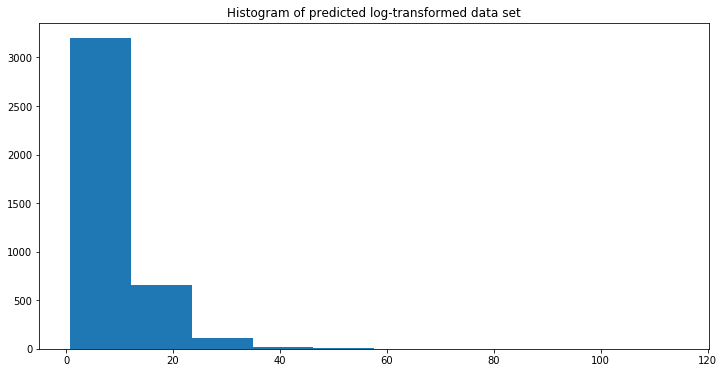

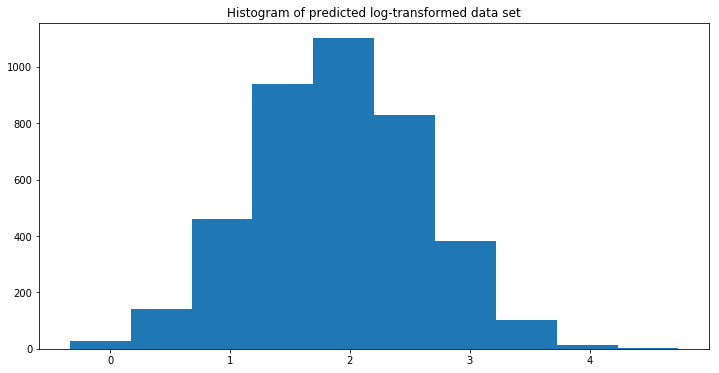

In [45]:
plt.figure(figsize=(12,6))
plt.hist(np.exp(posterior_samples['y_pred']))
plt.title('Histogram of predicted log-transformed data set')
plt.show()

plt.figure(figsize=(12,6))
plt.hist(posterior_samples['y_pred'])
plt.title('Histogram of predicted log-transformed data set')
plt.show()

## Stretch goal (optional)
Fit a mixture of two Gaussians to the HRTEM data set using Stan. Your likelihood function for each datum should be
That is, with probability p the log of the datum is generated from the first Gaussian and with probability (1 − p) it is generated from the second Gaussian. 
Produce plots and summaries of your posteriors over all parameters. Use samples from the posterior to show whether and how well the likelihood functions corresponding to the samples match the data histogram.
Note: You have to be really careful when fitting a mixture model like this one, since the posterior is always bimodal. For example if